In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import datetime
from collections import namedtuple

from stable_baselines3.common.vec_env.subproc_vec_env import SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env

from modular_baselines.loggers.basic import(InitLogCallback,
                                            LogRolloutCallback,
                                            LogWeightCallback,
                                            LogGradCallback)

from modular_baselines.vca.algorithm import DiscerteStateVCA
from modular_baselines.vca.buffer import Buffer
from modular_baselines.vca.collector import NStepCollector
from modular_baselines.vca.modules import (CategoricalPolicyModule,
                     CategoricalTransitionModule,
                     MultiheadCatgoricalTransitionModule,
                     CategoricalRewardModule)
from environment import MazeEnv


In [2]:
now = datetime.datetime.now().strftime("%m-%d-%Y-%H-%M-%S")
args = dict(
    state_size = 11,
    buffer_size = 10000,
    policy_hidden_size = 32,
    policy_tau = 1,
    transition_hidden_size = 32,
    transition_module_tau = 1,
    reward_set = [-1, 0, 1],
    reward_hidden_size = 16,
    reward_module_tau = 1,
    batchsize = 32,
    entropy_coef = 0.01,
    rollout_len=10,
    total_timesteps=int(1e4),
    device="cpu",
    log_interval=95,
    trans_lr=3e-3,
    policy_lr=3e-3,
    reward_lr=1e-3,
    use_gumbel=False,
    log_dir="logs/{}".format(now)
)
args = namedtuple("Args", args.keys())(*args.values())

In [3]:
env = MazeEnv()
vecenv = make_vec_env(lambda: MazeEnv())

rollout_callback = LogRolloutCallback()
init_callback = InitLogCallback(args.log_interval,
                                args.log_dir)
weight_callback = LogWeightCallback("weights.json")
grad_callback = LogGradCallback("grads.json")

buffer = Buffer(
    args.buffer_size,
    vecenv.observation_space,
    vecenv.action_space)

policy_m = CategoricalPolicyModule(
    vecenv.observation_space.n,
    vecenv.action_space.n,
    args.policy_hidden_size,
    tau=args.policy_tau,
    use_gumbel=args.use_gumbel)
trans_m = MultiheadCatgoricalTransitionModule(
    vecenv.observation_space.n,
    vecenv.action_space.n,
    state_set=torch.from_numpy(env.state_set),
    hidden_size=args.transition_hidden_size,
    tau=args.transition_module_tau,
    use_gumbel=args.use_gumbel)
reward_m = CategoricalRewardModule(
    vecenv.observation_space.n,
    env.reward_set,
    args.reward_hidden_size,
    tau=args.reward_module_tau)

collector = NStepCollector(
    env=vecenv,
    buffer=buffer,
    policy=policy_m,
    callbacks=[rollout_callback])
algorithm = DiscerteStateVCA(
    policy_module=policy_m,
    transition_module=trans_m,
    reward_module=reward_m,
    buffer=buffer,
    collector=collector,
    env=vecenv,
    reward_vals=env.expected_reward(),
    rollout_len=args.rollout_len,
    trans_opt=torch.optim.RMSprop(trans_m.parameters(), lr=args.trans_lr),
    policy_opt=torch.optim.RMSprop(policy_m.parameters(), lr=args.policy_lr),
    reward_opt=torch.optim.RMSprop(reward_m.parameters(), lr=args.reward_lr),
    batch_size=args.batchsize,
    entropy_coef=args.entropy_coef,
    device=args.device,
    callbacks=[init_callback, weight_callback, grad_callback]
)

Logging to logs/01-08-2021-22-15-26


/Users/tolga/anaconda/lib/python3.8/site-packages/pycolab/ascii_art.py:318: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  art = np.vstack(np.fromstring(line, dtype=np.uint8) for line in art)


In [4]:
algorithm.learn(args.total_timesteps)

---------------------------------
| time/              |          |
|    fps             | 825      |
|    iterations      | 0        |
|    time_elapsed    | 0        |
|    total_timesteps | 10       |
| train/             |          |
|    Reward loss     | 0.658    |
|    Transition loss | 3.74     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 160      |
|    ep_rew_mean     | -0.333   |
| time/              |          |
|    fps             | 1617     |
|    iterations      | 95       |
|    time_elapsed    | 0        |
|    total_timesteps | 960      |
| train/             |          |
|    Reward loss     | 0.227    |
|    Transition loss | 2.05     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -0.5     |
| time/              |          |
|    fps             | 1604     |
|    iteration

In [5]:
from visualizers.visualize import render_layout

render_layout(
    log_dir="logs/{}".format(now),
    layout=[["S", "S"], ["H", "H"]]
)

In [ ]:
path = "static/policy_m.b"
import os

os.makedirs("static", exist_ok=True)
with open(path, "wb") as bin_file:
    torch.save(policy_m.state_dict(), bin_file)

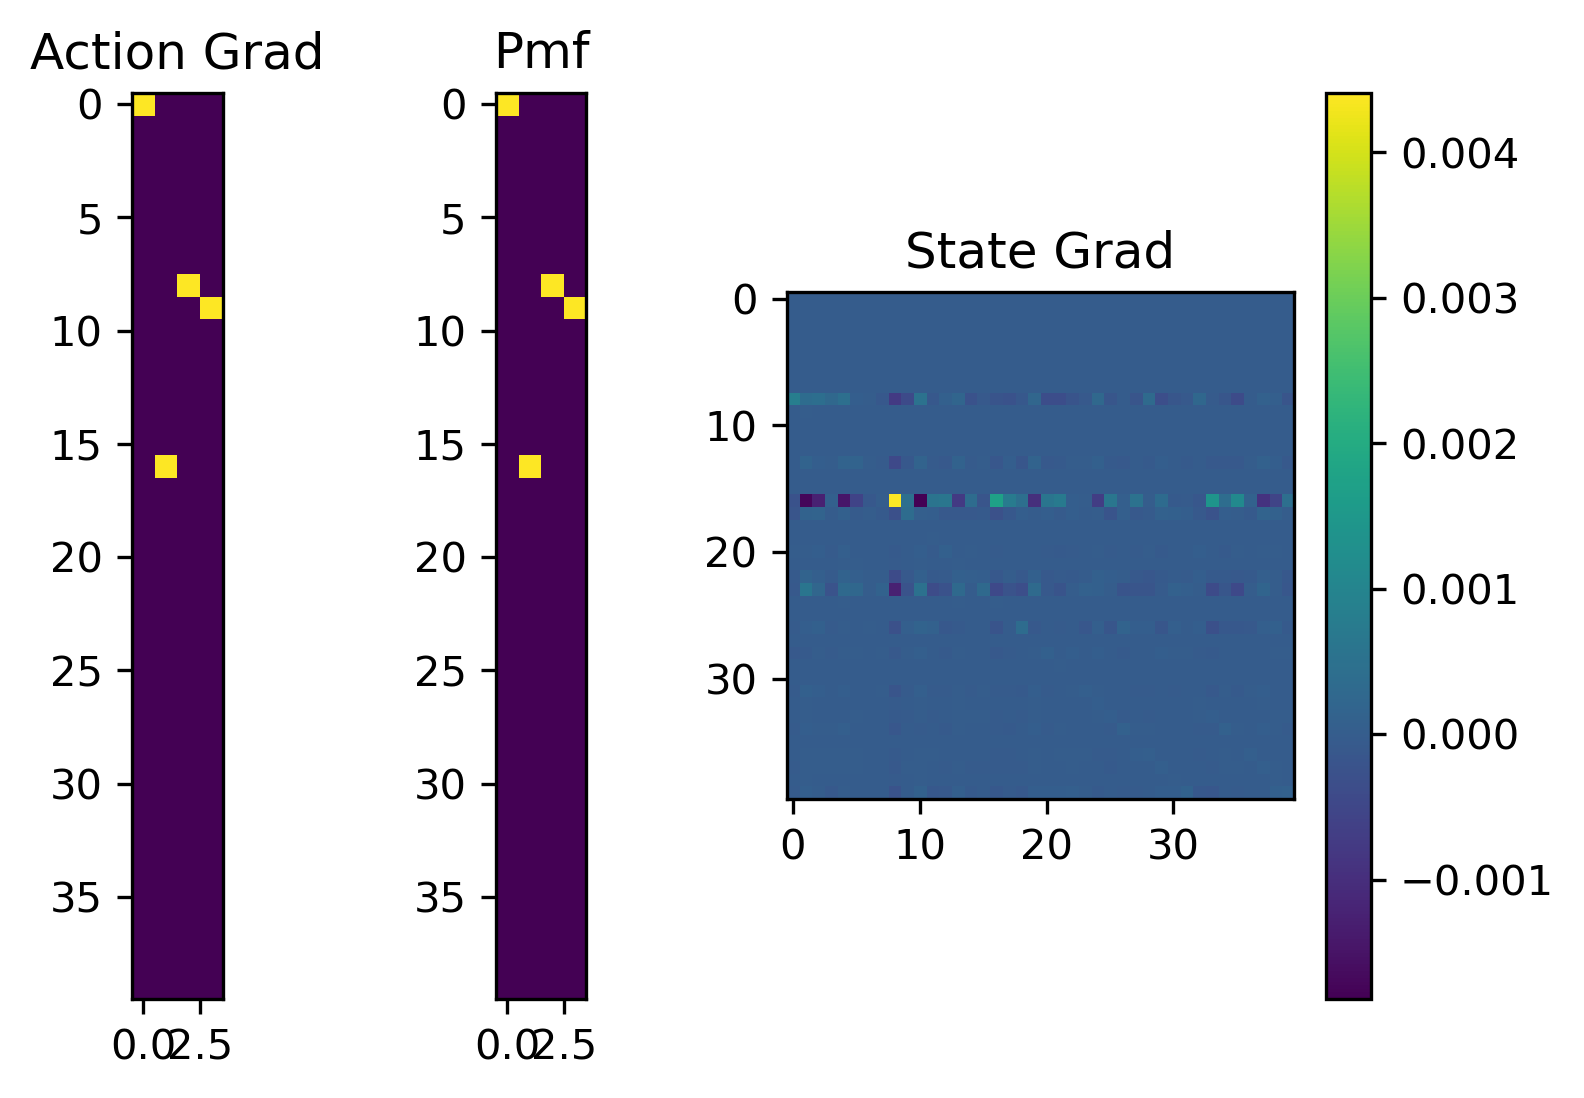

In [60]:
import matplotlib.pyplot as plt


def one_step_grad(init_state=8):
    jac_act = torch.zeros((4, env.observation_space.n, 4))
    jac_state = torch.zeros((4, env.observation_space.n, env.observation_space.n))
    
    r_state = (torch.ones((4, 1)) * init_state) == torch.arange(env.observation_space.n).reshape(1, -1)
    r_state = r_state.float()
    r_state.requires_grad = True
    r_state.retain_grad()
    
    action = torch.arange(4, requires_grad=False)
    r_action = algorithm._action_onehot(action.reshape(4, 1))
    r_action.requires_grad = True
    r_action.retain_grad()
    
    probs = algorithm.transition_module.dist(r_state, r_action)
    probs.retain_grad()

    for ix in range(env.observation_space.n):
        
        probs[:, ix].backward(torch.ones(4), retain_graph=True)
        jac_act[:, ix, :] = r_action.grad
        r_action.grad.zero_()
        
        jac_state[:, ix, :] = r_state.grad
        r_state.grad.zero_()
        
    return jac_act, jac_state, probs.detach().numpy().T

jax, jac_state, pmf = one_step_grad()

plt.figure(dpi=300)
plt.subplot(141)
plt.imshow(jax[1])
plt.title("Action Grad")
# plt.colorbar()

plt.subplot(142)
plt.imshow(pmf)
plt.title("Pmf")
# plt.colorbar()

plt.subplot(122)
plt.imshow(jac_state[1])
plt.title("State Grad")
plt.colorbar()


1.0


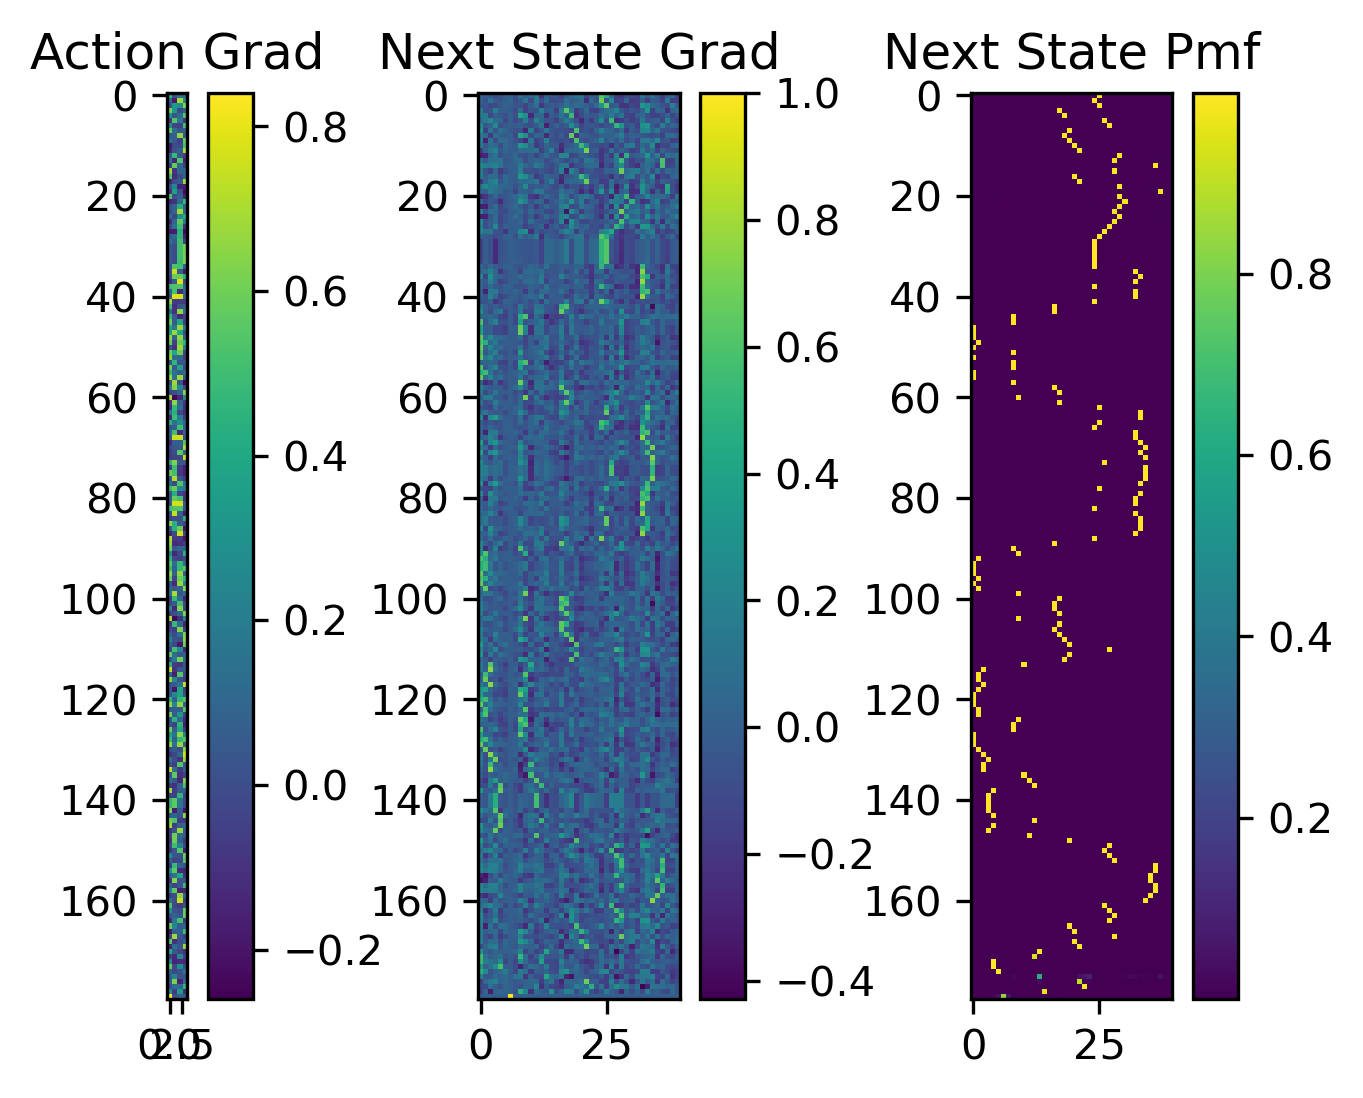

In [157]:
import matplotlib.pyplot as plt
from modular_baselines.vca.algorithm import GradNormalizer

def make_onehot_state(state):
    return ((torch.ones((1, 1)) * state) == torch.arange(env.observation_space.n).reshape(1, -1)).float()

def episode_grad(seed=1201):
    r_state_list = []
    r_action_list = []
    prob_list = []
    done = False
    env.action_space.seed(seed)
    
    state = env.reset()
    r_state = make_onehot_state(state)
    r_state = r_state.float()
    r_state.requires_grad = True
    r_state.retain_grad()
    
    while not done:
        action = env.action_space.sample()
        r_action = torch.tensor(action)
        next_state, _, done, _ = env.step(r_action)
        next_state = make_onehot_state(next_state)
        r_action = (r_action.float().reshape(1, 1) == torch.arange(env.action_space.n).reshape(1, -1)).float()
        r_action.requires_grad = True
        r_action.retain_grad()
        r_action_list.append(r_action)
        
        r_state = GradNormalizer.apply(r_state)
    
        probs = algorithm.transition_module.dist(r_state, r_action)
        prob_list.append(probs.detach())
        r_next_state = algorithm.transition_module.reparam(next_state, probs)
        r_next_state.retain_grad()
        r_state_list.append(r_next_state)

        r_state = r_next_state
        
                
    reward_tens = torch.from_numpy(env.expected_reward())
    exp_reward = (reward_tens * r_next_state).sum()
    exp_reward.backward()
    print(exp_reward.item())
        
    return r_action_list, r_state_list, prob_list

actions, states, pmfs = episode_grad()
eps_acts_grad = torch.cat(list(map(lambda act: act.grad, actions)), dim=0)
eps_state_grad = torch.cat(list(map(lambda state: state.grad, states)), dim=0)
eps_pmfs = torch.cat(pmfs, dim=0)


plt.figure(dpi=300)
# print(eps_acts_grad)
plt.subplot(131)
plt.imshow(eps_acts_grad)
plt.title("Action Grad")
plt.colorbar()

# print(eps_acts_grad)
plt.subplot(132)
plt.imshow(eps_state_grad)
plt.title("Next State Grad")
plt.colorbar()

# print(eps_acts_grad)
plt.subplot(133)
plt.imshow(eps_pmfs)
plt.title("Next State Pmf")
plt.colorbar()

In [67]:
from ipywidgets import Layout
import bqplot.pyplot as plt
from bqplot import ColorScale


c_sc = ColorScale(scheme="Blues")
axes_options = {"color": {"orientation": "vertical","side":"right"}}
heatmap_state = plt.heatmap(jac_state[1], scales={"color": c_sc}, axes_options=axes_options)
fig_state = plt.figure(title="State Jacobian",
                 layout=Layout(width="550px", height="550px"),
                 min_aspect_ratio=1, max_aspect_ratio=1, padding_y=0, marks=[heatmap_state])


# c_sc = ColorScale(scheme="Blues")
# heatmap_act = plt.heatmap(jax[1], scales={"color": c_sc}, axes_options=axes_options)
# fig_act = plt.figure(title="Action Jacobian",
#                  layout=Layout(width="250px", height="550px"),
#                  min_aspect_ratio=1, max_aspect_ratio=1, padding_y=0, marks=[heatmap_act])

# fig_prob = plt.figure(title="Pmf",
#                  layout=Layout(width="150px", height="550px"),
#                  min_aspect_ratio=1, max_aspect_ratio=1, padding_y=0)
# c_sc = ColorScale(scheme="Blues")
# heatmap_prop = plt.heatmap(pmf, scales={"color": c_sc}, axes_options=axes_options)





In [69]:
import ipywidgets as widgets

action_slider = widgets.IntSlider(value=1,
                        min=0,
                        max=env.action_space.n - 1,
                        step=1,
                        description="Input Action",
                        disabled=False,
                        continuous_update=False,
                        orientation="horizontal",
                        readout=True)

def update_action(change):
    #Update X-axis min/max value here
    if change["type"] == "change" and change["name"] == "value":
        act = change["new"]
        heatmap_state.color = jac_state[act]
    

action_slider.observe(update_action)
widgets.VBox([action_slider, widgets.HBox([fig_state])])

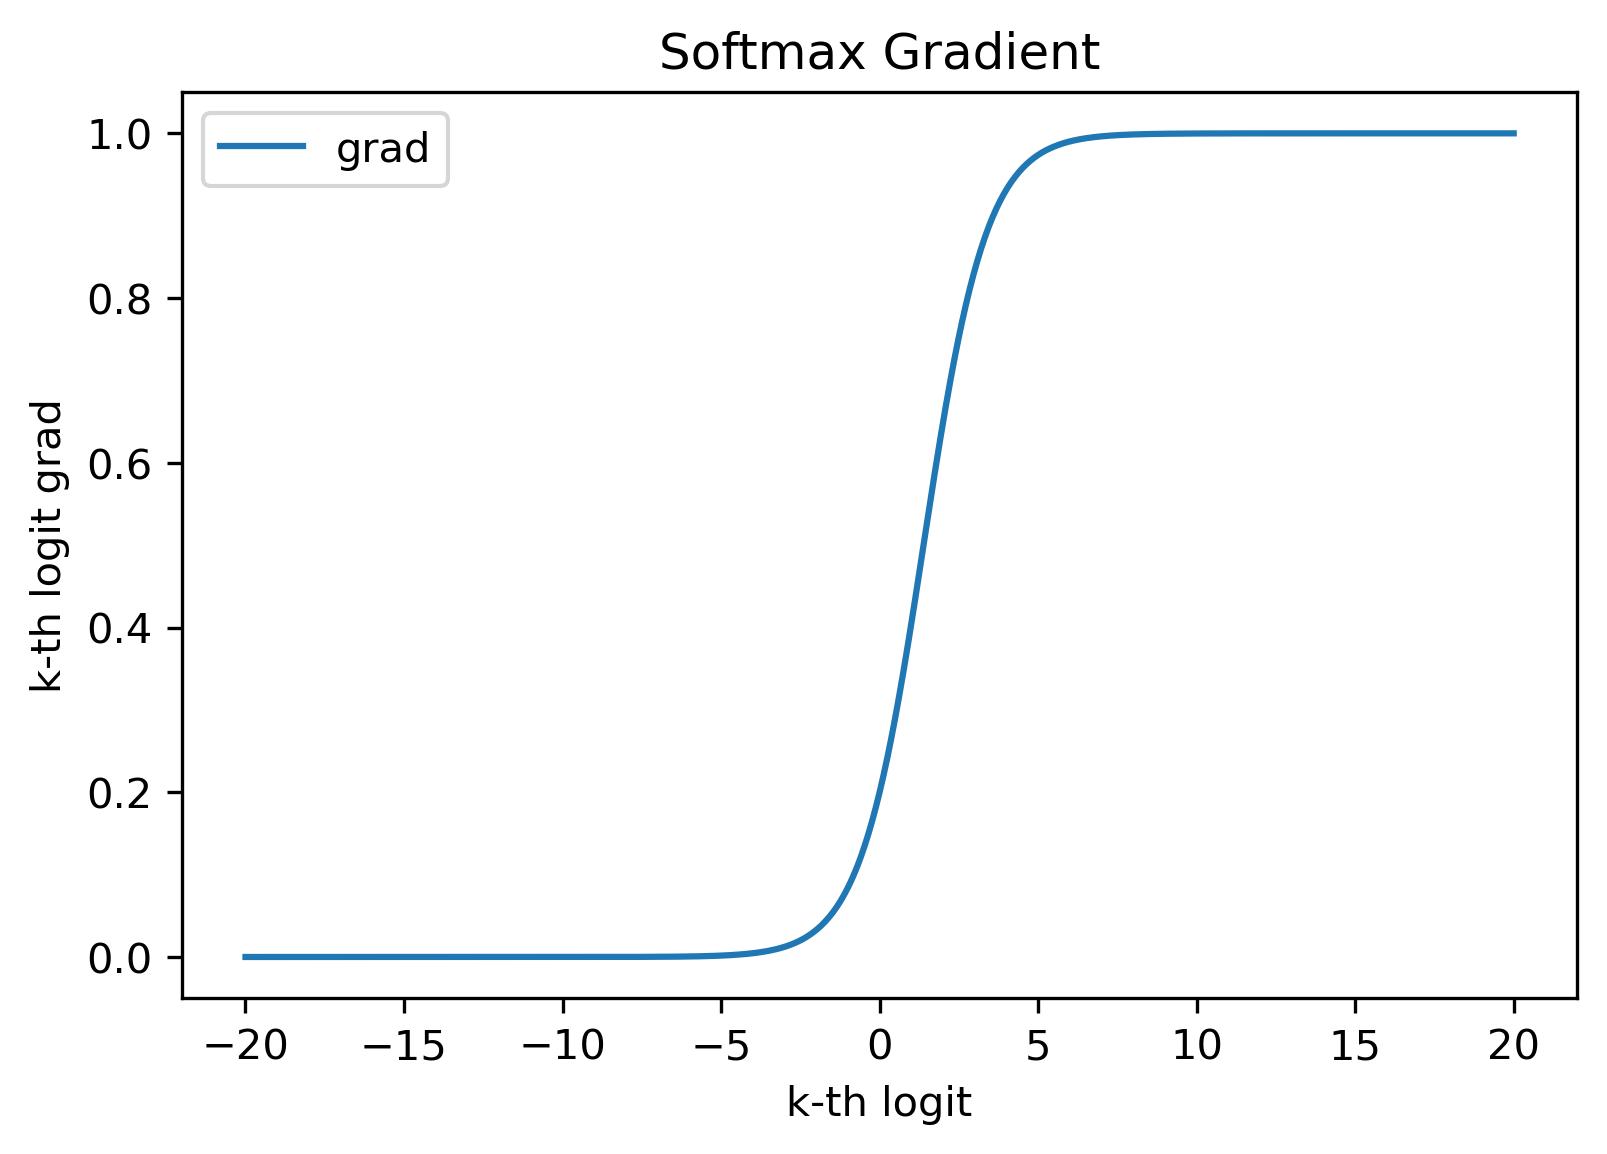

In [27]:
import matplotlib.pyplot as plt

def get_grad(logit_k=1):
    logit = torch.tensor([0., 0, 0, logit_k, 0], requires_grad=True)
    one_hot = (torch.arange(5) == 3).float()

    probs = torch.nn.functional.softmax(logit, dim=0)
#     out = (probs * one_hot)
    out = logit * one_hot * probs.detach()
    out = one_hot + out - out.detach()

    out.backward(torch.tensor([1., 1, 1, 1, 1]))
    return logit.grad[3], probs[3]


x = np.linspace(-20, 20, 1001)
y_grad, probs = list(zip(*[get_grad(logit_k=ix) for ix in x]))
plt.figure(dpi=300)
plt.plot(x, y_grad, label="grad")
# plt.plot(x, probs, label="prob")
plt.title("Softmax Gradient")
plt.xlabel("k-th logit")
plt.ylabel("k-th logit grad")
plt.legend()